# Depth Anything

In [ ]:
!git clone https://github.com/LiheYoung/Depth-Anything
%cd Depth-Anything
!pip install -r requirements.txt

Cloning into 'Depth-Anything'...
remote: Enumerating objects: 441, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 441 (delta 115), reused 44 (delta 41), pack-reused 280 (from 1)
Receiving objects: 100% (441/441), 237.90 MiB | 31.91 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Updating files: 100% (220/220), done.
/content/Depth-Anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: ma

In [ ]:
import argparse  # For parsing command-line arguments
import cv2  # OpenCV library for image and video processing
import numpy as np  # NumPy library for numerical computations
import os  # Operating system operations
import torch  # PyTorch library for deep learning
import torch.nn.functional as F  # Functional operations in PyTorch
from torchvision.transforms import Compose  # Compose transforms for image preprocessing
from tqdm import tqdm  # tqdm library for progress bars

# Importing the DepthAnything model and necessary transforms
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

# Setting parameters
# You can uncomment and modify these lines if you want to use different values
# encoder = 'vits'  # Choice of encoder for the Depth Anything model
video_path = 1  # Path to the input video file or camera index (1 for webcam)

margin_width = 50  # Width of the margin between raw image and depth map
caption_height = 60  # Height of the caption space

font = cv2.FONT_HERSHEY_SIMPLEX  # Font for text captions
font_scale = 1  # Font scale factor
font_thickness = 2  # Thickness of the font

# Selecting the device for inference ('cuda' if GPU available, otherwise 'cpu')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading the Depth Anything model
depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_vits14').to(DEVICE)

# Calculating the total number of parameters in the model
total_params = sum(param.numel() for param in depth_anything.parameters())
print('Total parameters: {:.2f}M'.format(total_params / 1e6))

# Setting the model to evaluation mode
depth_anything.eval()

# Defining image transformations
transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

raw_image = cv2.imread("/content/OIP (3).jpeg")

# Resize the raw image to a fixed size (640x480)
raw_image = cv2.resize(raw_image, (640, 480))

# Convert image to RGB format and normalize pixel values to [0, 1]
image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

# Apply transformations to the image
image = transform({'image': image})['image']
image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)

# Perform inference to get depth map
with torch.no_grad():
    depth = depth_anything(image)

# Resize the depth map to match the original image dimensions
depth = F.interpolate(depth[None], (480, 640), mode='bilinear', align_corners=False)[0, 0]

# Normalize depth values to [0, 255]
depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0

# Convert depth map tensor to numpy array
depth = depth.cpu().numpy().astype(np.uint8)

# Apply color mapping to visualize depth
depth_color = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/hub_mixin.py:824: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_file, map_location=torc

Total parameters: 24.79M


In [ ]:
image

tensor([[[[-1.8290, -1.6069, -1.7463,  ..., -2.1053, -2.1008, -2.1008],
          [-1.9421, -1.7211, -1.8532,  ..., -2.1041, -2.1008, -2.1008],
          [-1.9527, -1.7249, -1.8704,  ..., -2.1014, -2.1008, -2.1008],
          ...,
          [-1.5128, -1.7836, -2.0665,  ..., -2.0746, -1.8706, -1.6011],
          [-0.9597, -1.4503, -1.9945,  ..., -2.0392, -1.6236, -1.0700],
          [-0.9200, -1.4532, -1.9958,  ..., -2.0868, -1.7197, -1.1089]],

         [[-0.7929, -0.6354, -0.9473,  ..., -1.9863, -1.9832, -1.9832],
          [-0.9051, -0.7475, -1.0495,  ..., -1.9851, -1.9832, -1.9832],
          [-0.9599, -0.8140, -1.1009,  ..., -1.9823, -1.9832, -1.9832],
          ...,
          [-1.5054, -1.7700, -2.0108,  ..., -1.9914, -1.7829, -1.5074],
          [-0.9205, -1.4252, -1.9523,  ..., -1.9553, -1.5304, -0.9644],
          [-0.8811, -1.4283, -1.9540,  ..., -2.0039, -1.6286, -1.0042]],

         [[-0.6368, -0.4683, -0.7178,  ..., -1.7727, -1.7696, -1.7696],
          [-0.7676, -0.5826, -

array([[ 29,  29,  28, ...,  32,  33,  26],
       [ 28,  29,  29, ...,  32,  32,  33],
       [ 29,  29,  29, ...,  33,  33,  33],
       ...,
       [215, 213, 212, ..., 214, 213, 215],
       [214, 213, 213, ..., 213, 215, 215],
       [188, 212, 215, ..., 213, 217, 198]], dtype=uint8)
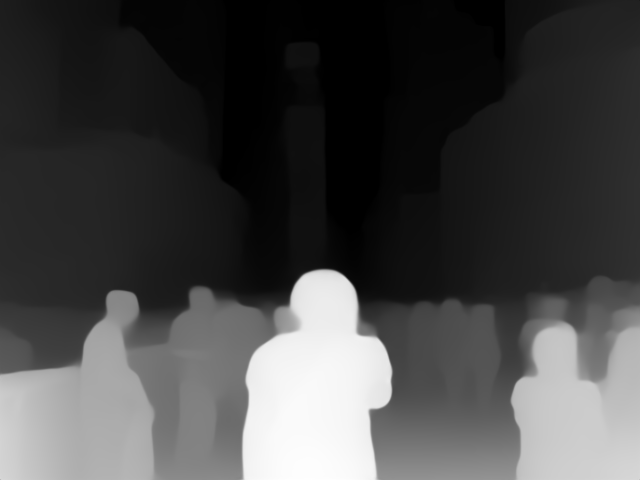

In [ ]:
depth

array([[[ 67,  12,  28],
        [ 67,  12,  28],
        [ 65,  12,  27],
        ...,
        [ 74,  12,  33],
        [ 76,  12,  35],
        [ 60,  12,  24]],

       [[ 65,  12,  27],
        [ 67,  12,  28],
        [ 67,  12,  28],
        ...,
        [ 74,  12,  33],
        [ 74,  12,  33],
        [ 76,  12,  35]],

       [[ 67,  12,  28],
        [ 67,  12,  28],
        [ 67,  12,  28],
        ...,
        [ 76,  12,  35],
        [ 76,  12,  35],
        [ 76,  12,  35]],

       ...,

       [[ 31, 186, 251],
        [ 26, 182, 251],
        [ 24, 180, 252],
        ...,
        [ 29, 184, 251],
        [ 26, 182, 251],
        [ 31, 186, 251]],

       [[ 29, 184, 251],
        [ 26, 182, 251],
        [ 26, 182, 251],
        ...,
        [ 26, 182, 251],
        [ 31, 186, 251],
        [ 31, 186, 251]],

       [[ 14, 135, 248],
        [ 24, 180, 252],
        [ 31, 186, 251],
        ...,
        [ 26, 182, 251],
        [ 35, 190, 251],
        [  6, 153, 251]]], dtype=uint8)
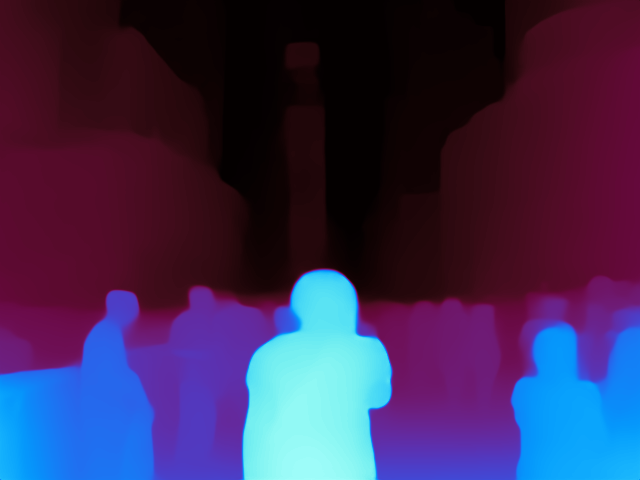

In [ ]:
depth_color

In [ ]:
!wget -P /content/Dataset1 https://huggingface.co/spaces/LiheYoung/Depth-Anything/blob/main/checkpoints_metric_depth/depth_anything_metric_depth_indoor.pt

--2024-11-11 20:07:26--  https://huggingface.co/spaces/LiheYoung/Depth-Anything/blob/main/checkpoints_metric_depth/depth_anything_metric_depth_indoor.pt
Resolving huggingface.co (huggingface.co)... 18.244.202.118, 18.244.202.68, 18.244.202.60, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54656 (53K) [text/html]
Saving to: ‘/content/Dataset1/depth_anything_metric_depth_indoor.pt’

depth_anything_metr 100%[===================>]  53.38K  --.-KB/s    in 0.01s   

2024-11-11 20:07:26 (4.78 MB/s) - ‘/content/Dataset1/depth_anything_metric_depth_indoor.pt’ saved [54656/54656]



In [ ]:
!wget -P /content/Dataset2 https://huggingface.co/spaces/LiheYoung/Depth-Anything/blob/main/checkpoints_metric_depth/depth_anything_metric_depth_outdoor.pt

--2024-11-11 20:07:31--  https://huggingface.co/spaces/LiheYoung/Depth-Anything/blob/main/checkpoints_metric_depth/depth_anything_metric_depth_outdoor.pt
Resolving huggingface.co (huggingface.co)... 18.244.202.118, 18.244.202.68, 18.244.202.60, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54672 (53K) [text/html]
Saving to: ‘/content/Dataset2/depth_anything_metric_depth_outdoor.pt’

depth_anything_metr 100%[===================>]  53.39K  --.-KB/s    in 0.01s   

2024-11-11 20:07:31 (4.63 MB/s) - ‘/content/Dataset2/depth_anything_metric_depth_outdoor.pt’ saved [54672/54672]



In [ ]:
!pip install -r /content/Depth-Anything/metric_depth/environment.yml

ERROR: Invalid requirement: 'name: zoe': Expected end or semicolon (after name and no valid version specifier)
    name: zoe
        ^ (from line 1 of /content/Depth-Anything/metric_depth/environment.yml)


In [ ]:
print(depth_anything.)

NameError: name 'depth_anything_metric_depth_indoor' is not defined

# Depth Anything V2

In [ ]:
!git clone https://huggingface.co/spaces/depth-anything/Depth-Anything-V2
%cd Depth-Anything-V2
!pip install -r requirements.txt

fatal: destination path 'Depth-Anything-V2' already exists and is not an empty directory.
/content/Depth-Anything-V2


In [ ]:
!wget -P /content https://huggingface.co/depth-anything/Depth-Anything-V2-Large/resolve/main/depth_anything_v2_vitl.pth?download=true

--2024-11-12 20:13:23--  https://huggingface.co/depth-anything/Depth-Anything-V2-Large/resolve/main/depth_anything_v2_vitl.pth?download=true
Resolving huggingface.co (huggingface.co)... 3.160.150.7, 3.160.150.2, 3.160.150.119, ...
Connecting to huggingface.co (huggingface.co)|3.160.150.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/ef/a0/efa040f8dfeabb0d7e03dde47070ea9d72db9ffe066eb5d6a44a7a2803a1477c/a7ea19fa0ed99244e67b624c72b8580b7e9553043245905be58796a608eb9345?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27depth_anything_v2_vitl.pth%3B+filename%3D%22depth_anything_v2_vitl.pth%22%3B&Expires=1731701604&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMTcwMTYwNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2VmL2EwL2VmYTA0MGY4ZGZlYWJiMGQ3ZTAzZGRlNDcwNzBlYTlkNzJkYjlmZmUwNjZlYjVkNmE0NGE3YTI4MDNhMTQ3N2MvYTdlYTE5ZmEwZWQ5OTI0NGU2N2I2MjRjNzJiODU4MG

In [ ]:
!mv "/content/depth_anything_v2_vitl.pth?download=true" "/content/depth_anything_v2_vitl.pth"

In [ ]:
import cv2
import torch

from depth_anything_v2.dpt import DepthAnythingV2

model = DepthAnythingV2(encoder='vitl', features=256, out_channels=[256, 512, 1024, 1024])
model.load_state_dict(torch.load('/content/depth_anything_v2_vitl.pth', map_location='cpu'))
model.eval()

raw_img = cv2.imread('/content/img 1.jfif')
depth = model.infer_image(raw_img) # HxW raw depth map


<ipython-input-5-2550ebafcbea>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/depth_anything_v2_vitl.pth', map_location='cpu'))


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
cv2_imshow(raw_img)

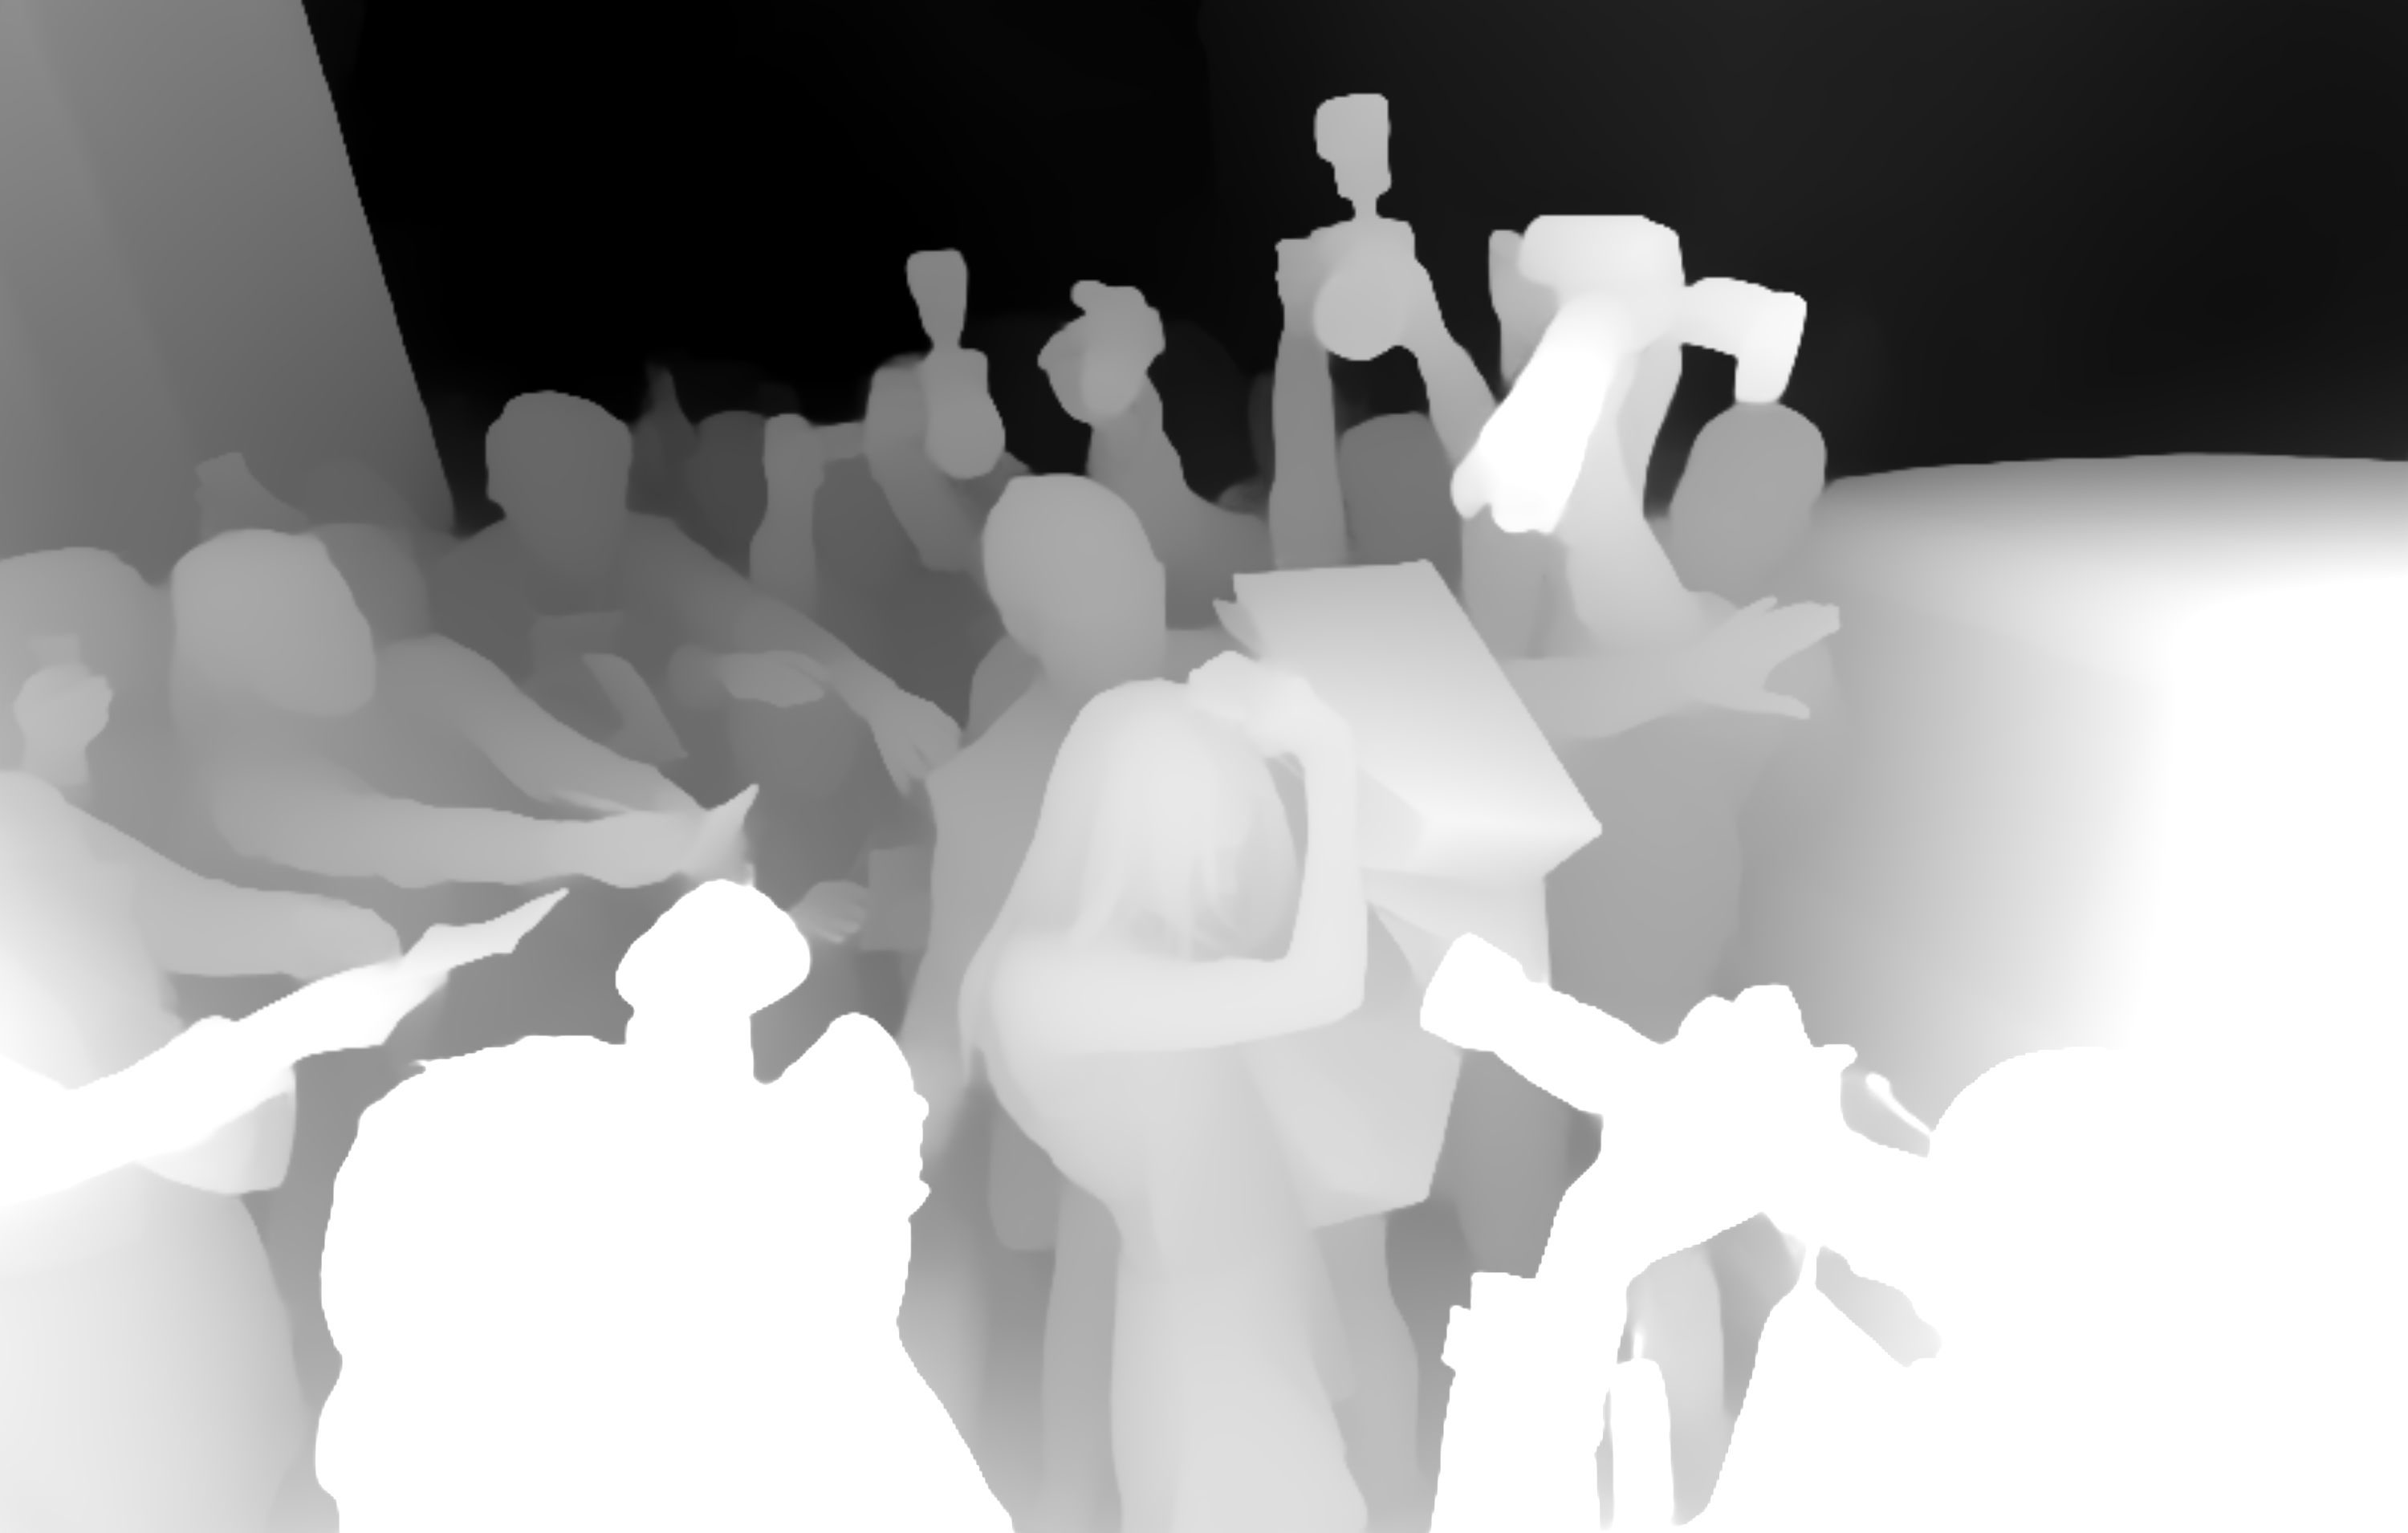

In [ ]:
cv2_imshow(depth)

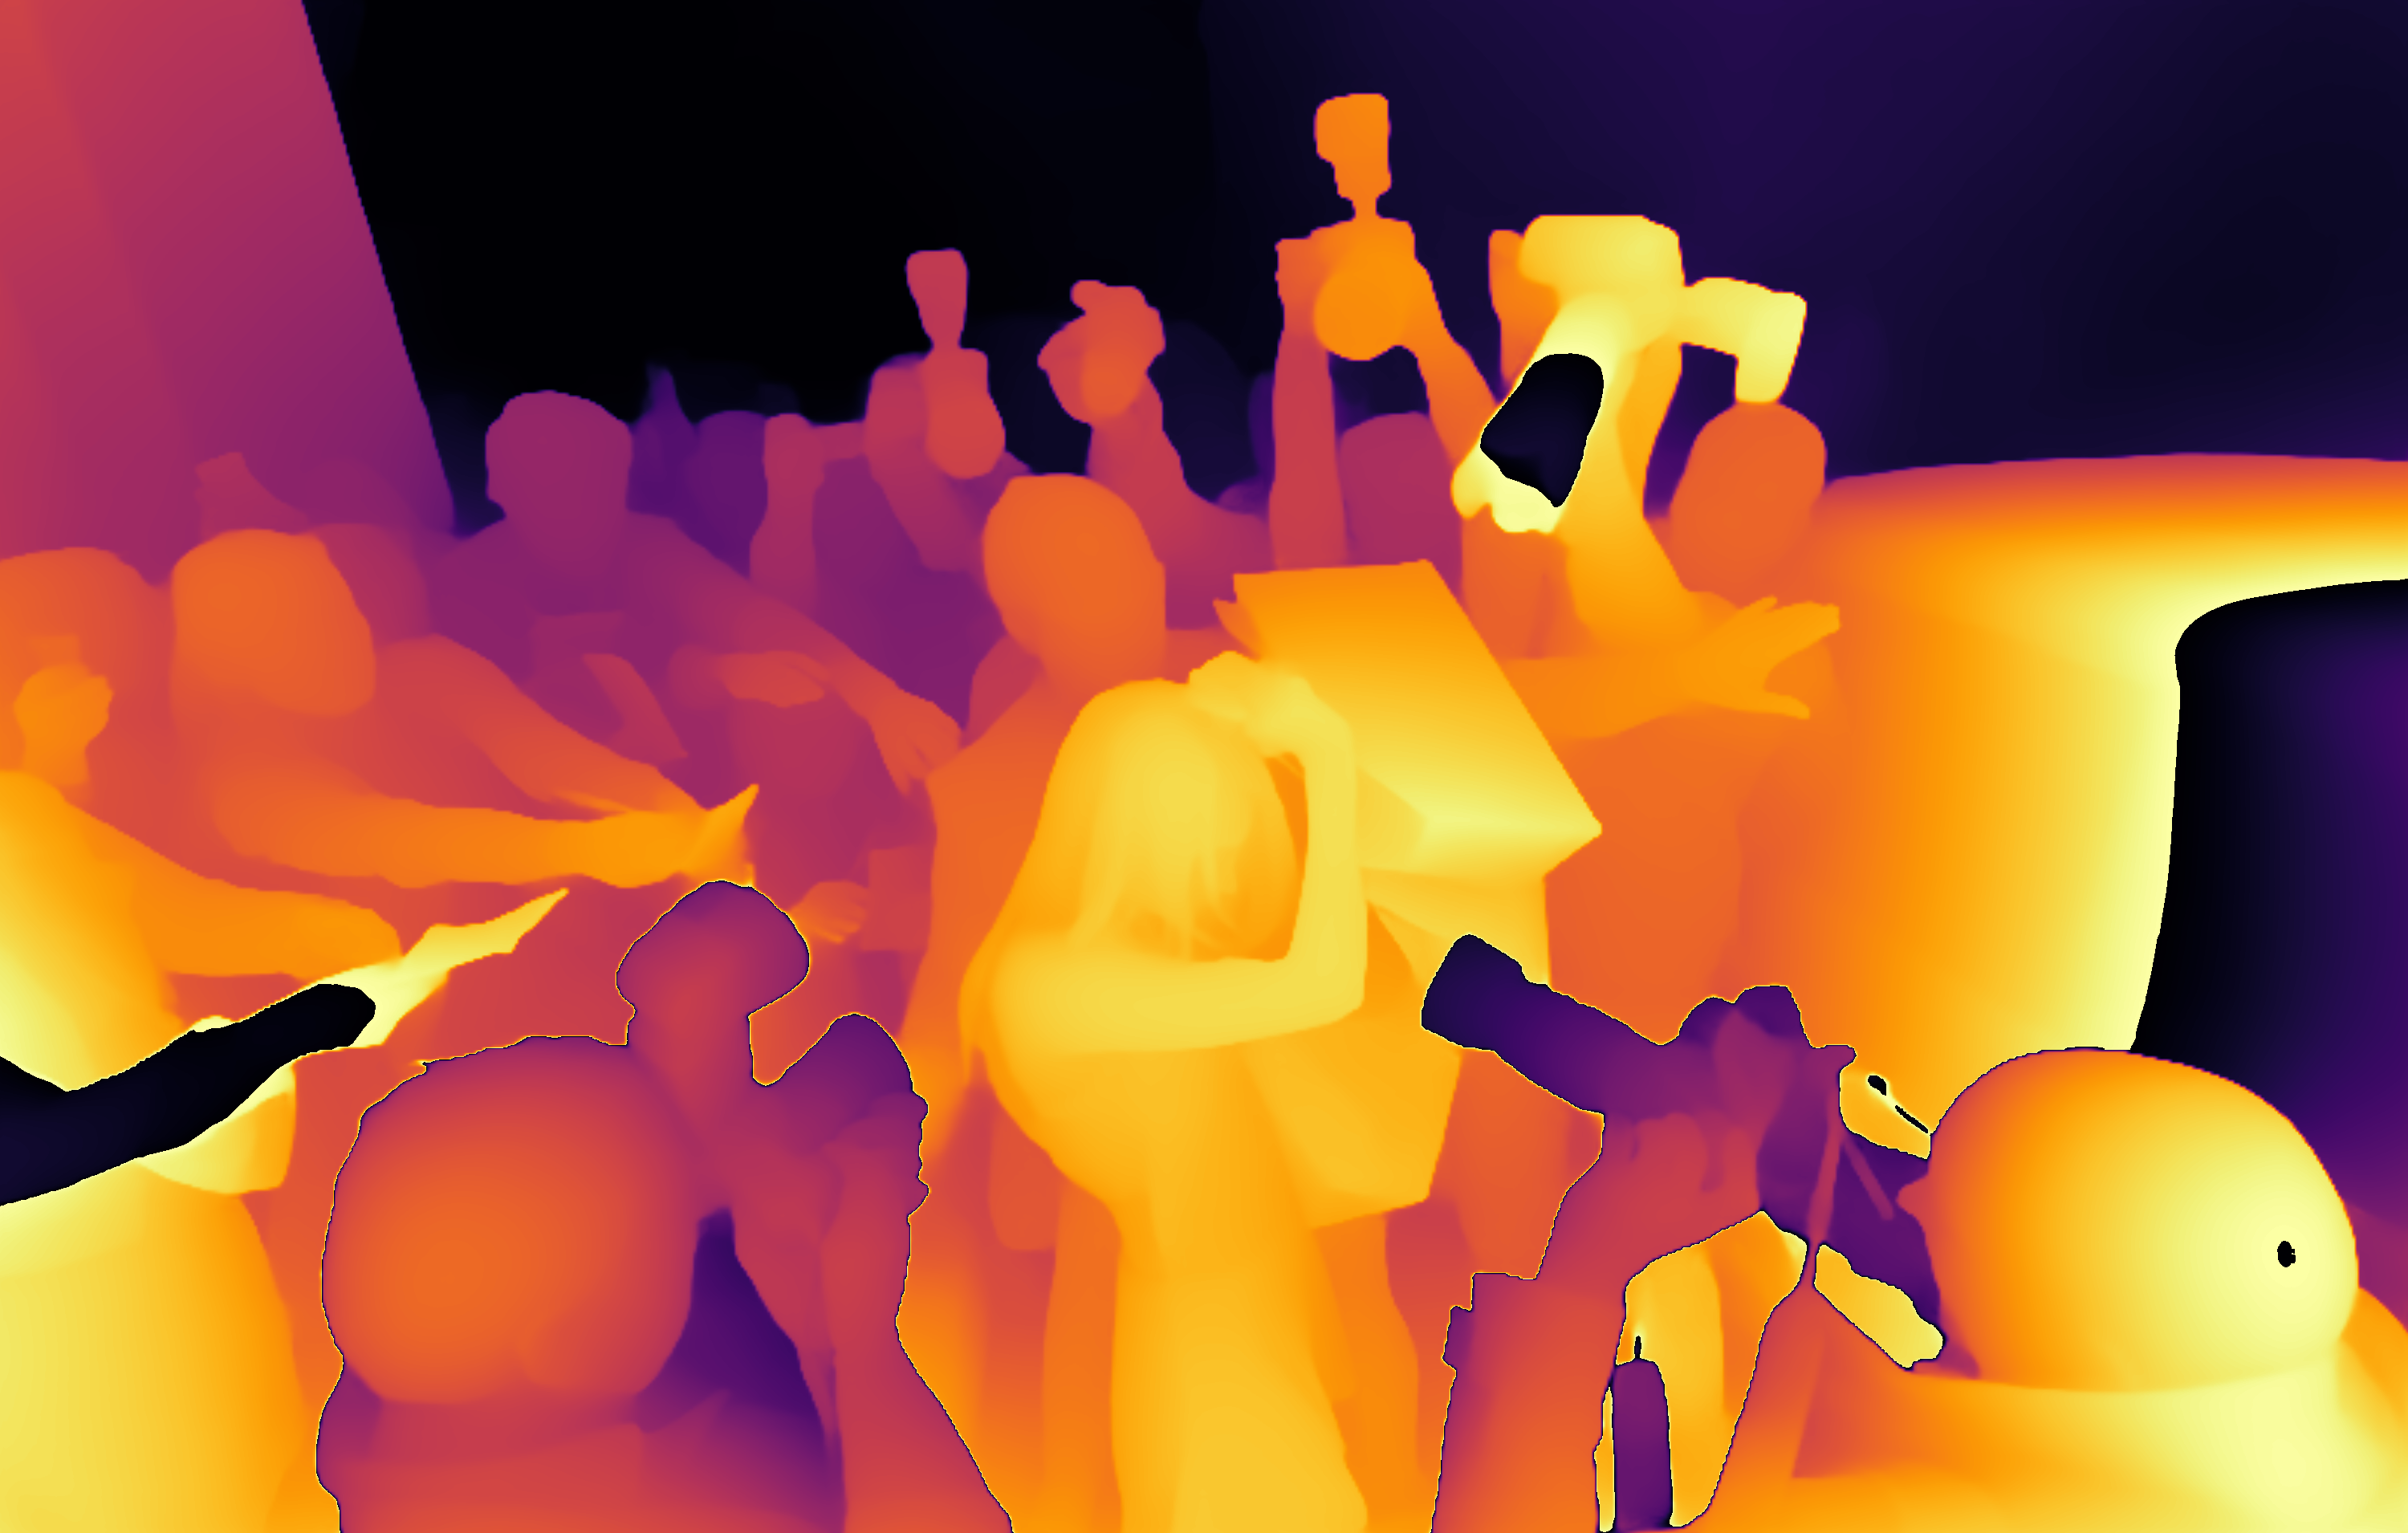

In [ ]:
import numpy as np
depth_uint8 = depth.astype(np.uint8)
depth_color = cv2.applyColorMap(depth_uint8, cv2.COLORMAP_INFERNO)
cv2_imshow(depth_color)

In [ ]:
depth

array([[126.209015, 125.35317 , 124.581894, ..., 108.45565 , 102.55658 ,
         96.24678 ],
       [126.17575 , 125.59404 , 125.075905, ..., 107.93514 , 105.13213 ,
        102.153564],
       [126.148834, 125.837234, 125.567375, ..., 107.46506 , 107.54999 ,
        107.675995],
       ...,
       [469.46283 , 468.1535  , 466.94675 , ..., 435.9759  , 435.9467  ,
        435.90942 ],
       [468.96307 , 468.09644 , 467.28067 , ..., 436.285   , 436.58942 ,
        436.87793 ],
       [468.32526 , 467.9988  , 467.66193 , ..., 436.59592 , 437.25607 ,
        437.89078 ]], dtype=float32)

In [ ]:
import cv2
import torch

from depth_anything_v2.dpt import DepthAnythingV2

model = DepthAnythingV2(encoder='vitl', features=256, out_channels=[256, 512, 1024, 1024])
model.load_state_dict(torch.load('/content/depth_anything_v2_vitl.pth', map_location='cpu'))
model.eval()

raw_img = cv2.imread('/content/OIP (3).jpeg')
depth = model.infer_image(raw_img) # HxW raw depth map

<ipython-input-4-46ac220825d9>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/depth_anything_v2_vitl.pth', map_location='cpu'))


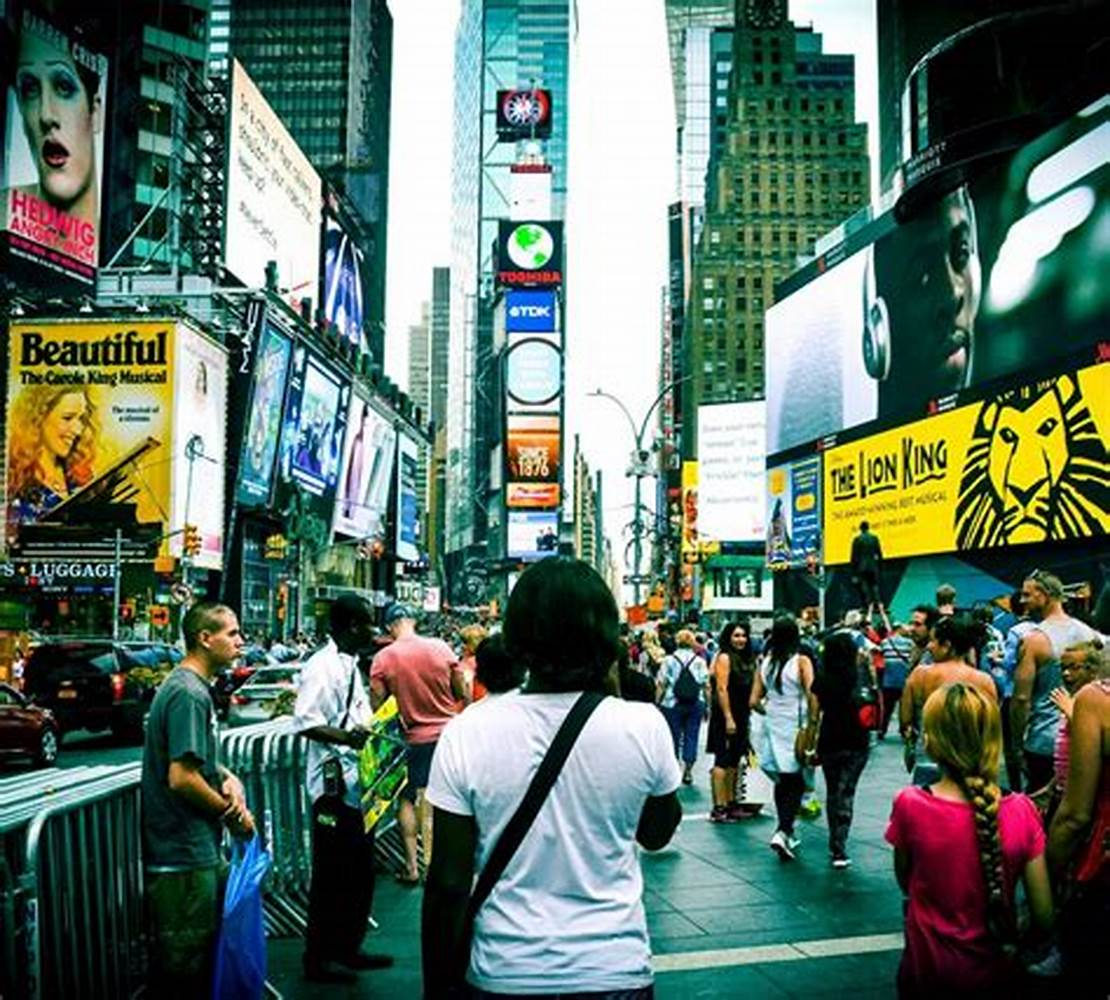

In [ ]:
cv2_imshow(raw_img)

In [ ]:
cv2_imshow(depth)

In [ ]:
import numpy as np
depth_uint8 = depth.astype(np.uint8)
depth_color = cv2.applyColorMap(depth_uint8, cv2.COLORMAP_INFERNO)
cv2_imshow(depth_color)